In [14]:
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os

from transformers import BertModel, BertTokenizer

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

## Connecting to Supabase + Loading Data

In [15]:
# Load environment variables from .env
load_dotenv()

# Fetch variables
USER = os.getenv("user")
PASSWORD = os.getenv("password")
HOST = os.getenv("host")
PORT = os.getenv("port")
DBNAME = os.getenv("dbname")

# Connect to the database
try:
    engine = create_engine(f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}")
    print("Connection successful!")

except Exception as e:
    print(f"Failed to connect: {e}")

Connection successful!


In [16]:
query = "SELECT id, combined_text, verdict FROM aita_posts;"
df = pd.read_sql_query(query, engine)

df.head()

,id,combined_text,verdict
0,1ytxov,aita write explanation til come condescend pos...,asshole
1,1yu29c,aita throw parent donut away parent diabetic m...,asshole
2,1yu8hi,tell goth girl look like clown,not the asshole
3,1yuc78,aita argument redditor r himym http://www.redd...,everyone sucks
4,1yueqb,aita let story little long boring person talk ...,not the asshole


## Testing BERT

Set up HuggingFace BERT model and load pre-trained weights

In [4]:
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

BERT tokenizer for preprocessing

In [5]:
sample_text = "Reddit posts can sometimes go viral overnight."

# Tokenize input text
inputs = tokenizer(
    sample_text,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors='pt'  # PyTorch tensors
)

print(inputs.keys())  # Input IDs and attention mask

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


## BERT Classifier

Define model class

In [6]:
class BERTClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 4)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state.mean(dim=1)
        x = self.dropout(pooled_output)

        return self.classifier(x)
    
    def train_model(self, train_loader, optimizer, loss_fn, device, epochs=3):
        self.train()
        for epoch in range(epochs): 
            loop = tqdm(train_loader, leave=True)
            for batch in loop:
                optimizer.zero_grad()

                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self(input_ids, attention_mask)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()

                loop.set_description(f'Epoch {epoch}')
                loop.set_postfix(loss=loss.item())

    def evaluate_model(self, test_loader, device):
        self.eval()
        predictions, true_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = self(input_ids, attention_mask)
                preds = torch.argmax(outputs, axis=1)

                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        # Metrics
        acc = accuracy_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions, average='weighted')

        print(f'Accuracy: {acc:.4f}')
        print(f'F1-Score: {f1:.4f}')

        return predictions, true_labels, acc, f1

Encode labels

In [7]:
label_encoder = LabelEncoder()
df['verdict_encoded'] = label_encoder.fit_transform(df['verdict'])
print(label_encoder.classes_)  # View label mappings

['asshole' 'everyone sucks' 'no assholes here' 'not the asshole']


Check for class imbalance

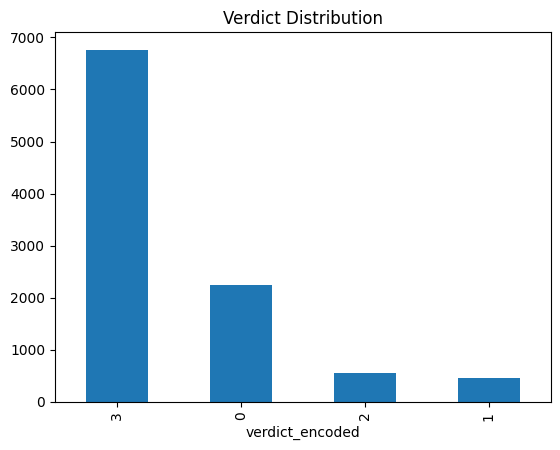

verdict_encoded
3    6764
0    2238
2     549
1     449
Name: count, dtype: int64

In [8]:
import matplotlib.pyplot as plt

df['verdict_encoded'].value_counts().plot(kind='bar')
plt.title("Verdict Distribution")
plt.show()

df['verdict_encoded'].value_counts()

Train-Test Split

In [9]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['combined_text'].values, 
    df['verdict_encoded'].values, 
    test_size=0.2, 
    random_state=42
)

Tokenize text

In [10]:
# Tokenize
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128, return_tensors='pt')

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

Dataset class

In [11]:
class RedditDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = RedditDataset(train_encodings, train_labels)
test_dataset = RedditDataset(test_encodings, test_labels)

Setup train and test loaders, and other things

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BERTClassifier()
model.to(device)

# Get unique classes and compute weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels.numpy()),
    y=train_labels.numpy()
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Training

In [13]:
model.train_model(train_loader, optimizer, loss_fn, device, epochs=8)

Epoch 0:   3%|▎         | 13/500 [08:01<5:00:20, 37.00s/it, loss=1.3] 


KeyboardInterrupt: 

In [ ]:
predictions, true_labels, acc, f1 = model.evaluate_model(test_loader, device)

print(classification_report(true_labels, predictions, target_names=label_encoder.classes_))

Accuracy: 0.2564
F1-Score: 0.2141
